In [1]:
import numpy as np
import pyblp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import default_rng
from scipy.optimize import root
import scipy.sparse as sp


import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from pathlib import Path

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.2'

## Data Generation

In [2]:
def foc_norm(p, x_t, xi_t, mc_t):
    r = foc_residuals(p, x_t, xi_t, mc_t)
    return np.max(np.abs(r)), r

def ms_mapping_gap(p, x_t, xi_t, mc_t):
    s, dsdp = sim_shares_and_jacobian(p, x_t, xi_t)
    gap = p - (mc_t - s / np.diag(dsdp))  # zero at fixed point
    return np.max(np.abs(gap)), gap

def sim_shares_and_jacobian(p_t, x_t, xi_t):
    """
    Inputs:
    p_t  : (J,) prices in market t
    x_t  : (J,) quality draws for market t
    xi_t : (J,) demand unobservable for market t
    Returns:
    s_mean : (J,) simulated market shares (inside goods)
    dsdp   : (J, J) Jacobian ds_j/dp_k
    Details:
    Individual utility (up to i.i.d. EV1): v_ij = TRUE_BETA1*x_j + beta2_i*sat_j + beta3_i*wir_j + TRUE_ALPHA*p_j + xi_j
    s_ij = exp(v_ij) / (1 + sum_k exp(v_ik))  (outside utility normalized to 0)
    Aggregate s_j = E_i[s_ij] via R-draw simulation.
    Derivative under the integral (per draw): ∂s_ij/∂p_k = TRUE_ALPHA * s_ij * (1{j=k} - s_ik)
    => dsdp[j,k] = E_i[ ∂s_ij/∂p_k ] (Monte Carlo average).
    """
    # v_i (R,J): random coeffs enter via sat/wir dummies
    v = (TRUE_BETA1 * x_t[None, :]
        + beta2_draws[:, None] * is_sat[None, :]
        + beta3_draws[:, None] * is_wir[None, :]
        + TRUE_ALPHA * p_t[None, :]
        + xi_t[None, :])  # shape (R, J)

    exp_v = np.exp(v - np.max(v, axis=1, keepdims=True))  # safe stab.
    denom = 1.0 + np.sum(exp_v, axis=1, keepdims=True)    # add outside option
    s_ind = exp_v / denom                                 # (R, J)
    s_mean = s_ind.mean(axis=0)                           # (J,)

    # Jacobian: ds_j/dp_k = E_i[ TRUE_ALPHA * s_ij * (1{j=k} - s_ik) ]
    dsdp = np.empty((J, J))
    for k in range(J):
        factor = TRUE_ALPHA * (np.eye(J)[k][None, :] - s_ind)  
        dsdp[:, k] = np.mean(s_ind * factor, axis=0)
    return s_mean, dsdp

def foc_residuals(p_t, x_t, xi_t, mc_t):
    s, dsdp = sim_shares_and_jacobian(p_t, x_t, xi_t)
    # Single-product FOCs: (p_j - mc_j)*ds_j/dp_j + s_j = 0  for each j
    diag = np.diag(dsdp)  
    return (p_t - mc_t) * diag + s

def solve_equilibrium_root(x_t, xi_t, mc_t, p0=None, tol=1e-12):
    # Root-finding on the J FOCs
    if p0 is None:
        p0 = mc_t + 1.0  # mild markup starting point
    sol = root(lambda p: foc_residuals(p, x_t, xi_t, mc_t), p0, method='hybr', tol=tol)
    return sol.x, sol.success, sol.nfev

# ------------------------------------------------------
# Morrow–Skerlos Fixed-Point (MSFP) mapping per market
# ------------------------------------------------------
def msfp_prices(x_t, xi_t, mc_t, p0=None, max_iter=5000, tol=1e-10, damp=0.8):
    """
    p_{n+1} = mc - diag(dsdp(p_n))^{-1} s(p_n)
    Optional damping for stability.
    """
    if p0 is None:
        p = mc_t + 1.0
    else:
        p = p0.copy()
    for it in range(max_iter):
        s, dsdp = sim_shares_and_jacobian(p, x_t, xi_t)
        diag = np.diag(dsdp)
        # Guard: own-prices derivatives should be negative
        if np.any(diag >= 0):
            # If happens, try to bail with small step toward mc
            p = 0.5 * (p + mc_t)
            continue
        p_new = mc_t - s / diag
        # damping
        p_next = damp * p_new + (1.0 - damp) * p
        # convergence
        if np.max(np.abs(p_next - p)) < tol:
            return p_next, True, it + 1
        p = p_next
    return p, False, max_iter

In [3]:
rng = default_rng(12345)  # reproducible
T = 600                    # markets
J = 4                      
R = 100              
# Demand parameters
TRUE_BETA1 = 1.0                
TRUE_ALPHA = -2.0               
# random coefficients: beta2_i ~ N(4,1) on satellite, beta3_i ~ N(4,1) on wired
TRUE_MU2, TRUE_SD2 = 4.0, 1.0
TRUE_MU3, TRUE_SD3 = 4.0, 1.0
# Cost parameters
gamma0 = 0.5
gamma1 = 0.25
# Correlated unobservables (xi, omega): N(0,0; 1, 0.25; 0.25, 1)
Sigma = np.array([[1.0, 0.25],
                [0.25, 1.0]])
# Product identities: j=0,1 are satellite; j=2,3 are wired
is_sat = np.array([1, 1, 0, 0], dtype=int)
is_wir = 1 - is_sat

# Exogenous characteristics and cost shifter: abs(N(0,1))
x = np.abs(rng.standard_normal((T, J)))
w = np.abs(rng.standard_normal((T, J)))

z = rng.multivariate_normal(mean=np.zeros(2), cov=Sigma, size=T*J)
xi = z[:, 0].reshape(T, J)
omega = z[:, 1].reshape(T, J)

# Marginal costs: ln mc_jt = gamma0 + gamma1 * w_jt + omega_jt/8
mc = np.exp(gamma0 + gamma1 * w + omega / 8.0)  # shape (T, J)

beta2_draws = TRUE_MU2 + TRUE_SD2 * rng.standard_normal(R)   # satellite taste
beta3_draws = TRUE_MU3 + TRUE_SD3 * rng.standard_normal(R)   # wired taste

# -------------------------
prices_root = np.empty((T, J))
succ_root   = np.zeros(T, dtype=bool)
evals_root  = np.zeros(T, dtype=int)

prices_msfp = np.empty((T, J))
succ_msfp   = np.zeros(T, dtype=bool)
iters_msfp  = np.zeros(T, dtype=int)

for t in range(T):
    # Root-solver

    # MSFP, warm-start at root solution (or mc+1 if root failed)
    p0 = (mc[t] + 1.0)
    p_ms, ok_ms, it_ms = msfp_prices(x[t], xi[t], mc[t], p0=p0, max_iter=2000, tol=1e-12, damp=0.85)
    prices_msfp[t] = p_ms
    succ_msfp[t] = ok_ms
    iters_msfp[t] = it_ms

    p_star, ok, nfev = solve_equilibrium_root(x[t], xi[t], mc[t], p0=p_ms)
    prices_root[t] = p_star
    succ_root[t] = ok
    evals_root[t] = nfev


# -------------------------------------------
shares_root = np.empty((T, J))
shares_msfp = np.empty((T, J))
for t in range(T):
    s_r, _ = sim_shares_and_jacobian(prices_root[t], x[t], xi[t])
    s_m, _ = sim_shares_and_jacobian(prices_msfp[t], x[t], xi[t])
    shares_root[t] = s_r
    shares_msfp[t] = s_m

# -------------------------
print(f"Root-solver success: {succ_root.mean():.3f} of markets")
print(f"MSFP success:        {succ_msfp.mean():.3f} of markets")

# Compare the two methods (they should match very closely if both converged)
diff = np.abs(prices_root - prices_msfp)
print("Max |price_root - price_msfp|:", np.nanmax(diff))

t = 0  # pick a market to inspect
p_r = prices_root[t]
p_m = prices_msfp[t]

fn_r, rvec_r = foc_norm(p_r, x[t], xi[t], mc[t])
fn_m, rvec_m = foc_norm(p_m, x[t], xi[t], mc[t])
mg_r, gvec_r = ms_mapping_gap(p_r, x[t], xi[t], mc[t])
mg_m, gvec_m = ms_mapping_gap(p_m, x[t], xi[t], mc[t])

print("Root solution:  max FOC residual =", fn_r, " | max MS gap =", mg_r)
print("MSFP solution:  max FOC residual =", fn_m, " | max MS gap =", mg_m)
print("max |p_root - p_msfp| =", np.max(np.abs(p_r - p_m)))

# Optional: assemble a tidy DataFrame to export
records = []
for t in range(T):
    for j in range(J):
        nest_ids = 1 if (j + 1 ) == 1 or (j + 1) == 0 else 1
        records.append({
            "market_ids": t+1,
            "product_ids": j+1,
            #"nesting_ids": nest_ids,
            "is_satellite": is_sat[j],
            "is_wired": is_wir[j],
            "x": x[t, j],
            "w": w[t, j],
            "xi": xi[t, j],
            "omega": omega[t, j],
            "mc": mc[t, j],
            "prices": prices_root[t, j],
            "shares": shares_root[t, j],
        })

      
        
data = pd.DataFrame.from_records(records)
for c in data.columns:
    data[c] = pd.to_numeric(data[c])
data.to_csv("simulated_data.csv", index=False)
print(data.head())


Root-solver success: 1.000 of markets
MSFP success:        1.000 of markets
Max |price_root - price_msfp|: 2.318145675417327e-13
Root solution:  max FOC residual = 5.551115123125783e-17  | max MS gap = 4.440892098500626e-16
MSFP solution:  max FOC residual = 7.210898544940392e-14  | max MS gap = 1.6120438317557273e-13
max |p_root - p_msfp| = 1.6120438317557273e-13
   market_ids  product_ids  is_satellite  is_wired         x         w  \
0           1            1             1         0  1.423825  1.065850   
1           1            2             1         0  1.263728  0.309725   
2           1            3             0         1  0.870662  0.051537   
3           1            4             0         1  0.259173  1.372945   
4           2            1             1         0  0.075343  0.137299   

         xi     omega        mc    prices    shares  
0 -0.578893  0.554603  2.306631  2.830617  0.042903  
1  1.305041 -0.000393  1.781369  2.611541  0.372759  
2 -1.340123 -0.923868  1.4

### Estimate Some Mis-specified Models

In [4]:
ln_s_0t = - np.log(1.0 - shares_root.sum(axis=1))  # (T,)
diff_ln_s_jt = np.log(shares_root) - np.repeat(ln_s_0t[:, None], J, axis=1)  # (T,J)

diff_ln_s_jt_vec = diff_ln_s_jt.flatten()  # (T*J,)

X = [data['x'].values, data["is_satellite"].values, data['prices'].values]
X_mat = np.column_stack(X)
model = sm.OLS(diff_ln_s_jt_vec, X_mat)
results_OLS = model.fit()
print(results_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          1.119e+04
Date:                Sun, 26 Oct 2025   Prob (F-statistic):                        0.00
Time:                        23:15:10   Log-Likelihood:                         -3054.9
No. Observations:                2400   AIC:                                      6116.
Df Residuals:                    2397   BIC:                                      6133.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 5

In [5]:
data_IV = pd.DataFrame({
    "y":        pd.Series(diff_ln_s_jt_vec).astype(float),
    "x":        pd.Series(data["x"]).astype(float),
    "prices":   pd.Series(data["prices"]).astype(float),
    "w":        pd.Series(data["w"]).astype(float),
    "is_satellite": pd.Series(data["is_satellite"]).astype(int)  # 0/1
}).dropna()

results_IV = IV2SLS.from_formula(
    "y ~ x + is_satellite + [prices ~ w]",
    data=data_IV
).fit(cov_type="robust")

print(results_IV.summary)   # note: no parentheses


                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.9329
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9328
No. Observations:                2400   F-statistic:                 2.841e+04
Date:                Sun, Oct 26 2025   P-value (F-stat)                0.0000
Time:                        23:15:10   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
x                0.6371     0.0345     18.478     0.0000      0.5695      0.7047
is_satellite     0.1198     0.0414     2.889

In [6]:
def grab(series_like, name):
    """Safely pick coefficient by name; return NaN if missing."""
    try:
        return float(series_like[name])
    except Exception:
        return np.nan

row_order = [
    ("$\\alpha$ (price)", "prices"),
    ("$\\beta_1$ (x)", "x"),
    ("$\\beta_2$ (satellite)", "is_satellite")
]

table_data = pd.DataFrame(
    {
        "True value": [
            TRUE_ALPHA,
            TRUE_BETA1,
            " "
        ],
        "OLS": [
            results_OLS.params[2],
            results_OLS.params[0],
            results_OLS.params[1],
        ],
        "IV-2SLS (robust)": [
            grab(results_IV.params, "prices"),
            grab(results_IV.params, "x"),
            grab(results_IV.params, "is_satellite"),
        ],
    },
    index=[r[0] for r in row_order],
)

# (Optional) add SEs as extra rows; comment out if you prefer a compact table
add_ses = True
if add_ses:
    se_rows = pd.DataFrame(
        {
            "True value": ["", "", ""],
            "OLS": [
                results_OLS.bse[2],
                results_OLS.bse[0],
                results_OLS.bse[1],
            ],
            "IV-2SLS (robust)": [
                grab(results_IV.std_errors, "prices"),
                grab(results_IV.std_errors, "x"),
                grab(results_IV.std_errors, "is_satellite"),
            ],
        },
        index=[r + " (s.e.)" for r in [ro[0] for ro in row_order]],
    )
    table_data = pd.concat([table_data, se_rows], axis=0)

# ===============================
# 5) Write LaTeX to file
# ===============================
out_path = Path("latex/table_exercise_4.tex").resolve()
latex_str = table_data.to_latex(
    index=True,
    float_format="%.3f",
    column_format="lccc",
    caption="True parameters vs. OLS and IV-2SLS estimates",
    label="tab:exercise_4",
    escape=False
)
out_path.write_text(latex_str, encoding="utf-8")
print(f"\nLaTeX table written to: {out_path}")

# If you prefer to also save a CSV for quick checking:
table_data.to_csv("latex/table_exercise_4.csv", index=True)
print("CSV written to: latex/table_exercise_4.csv")


LaTeX table written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_4.tex
CSV written to: latex/table_exercise_4.csv


### 6

In [7]:
df_exercise_6 = pd.read_csv("simulated_data.csv")

# 1) Outside share and log share ratio
mkt_sum = df_exercise_6.groupby("market_ids")["shares"].sum().rename("sum_share_mkt")
df_exercise_6 = df_exercise_6.merge(mkt_sum, on="market_ids", how="left")
df_exercise_6["s0"] = (1.0 - df_exercise_6["sum_share_mkt"]).clip(lower=1e-12)
df_exercise_6["ln_sj_s0"] = np.log(df_exercise_6["shares"].clip(lower=1e-12)) - np.log(df_exercise_6["s0"])

# 2) Boolean masks for nests
mask_sat = df_exercise_6["is_satellite"].astype(bool)
mask_wir = df_exercise_6["is_wired"].astype(bool)

# 3) Nest totals S_{g,t}
S_sat = (df_exercise_6.assign(sat_share=np.where(mask_sat, df_exercise_6["shares"], 0.0))
           .groupby("market_ids")["sat_share"].transform("sum"))
S_wir = (df_exercise_6.assign(wir_share=np.where(mask_wir, df_exercise_6["shares"], 0.0))
           .groupby("market_ids")["wir_share"].transform("sum"))

# 4) Within-nest logs (0 for products not in that nest)
df_exercise_6["ln_within_sat"] = 0.0
valid_sat = mask_sat & (S_sat > 0)
df_exercise_6.loc[valid_sat, "ln_within_sat"] = np.log((df_exercise_6.loc[valid_sat, "shares"] / S_sat[valid_sat]).clip(lower=1e-12))

df_exercise_6["ln_within_wired"] = 0.0
valid_wir = mask_wir & (S_wir > 0)
df_exercise_6.loc[valid_wir, "ln_within_wired"] = np.log((df_exercise_6.loc[valid_wir, "shares"] / S_wir[valid_wir]).clip(lower=1e-12))


formula = (
    "ln_sj_s0 ~  x + ln_within_sat + ln_within_wired "
    "[prices ~ w]"
)
iv_res = IV2SLS.from_formula(formula, data=df_exercise_6).fit(
    cov_type="clustered", clusters=df_exercise_6["market_ids"]
)
print(iv_res.summary)

# Coefs
beta_x    = iv_res.params["x"]
alpha_p   = iv_res.params["prices"]
sigma_sat = iv_res.params["ln_within_sat"]
sigma_wir = iv_res.params["ln_within_wired"]
print("\nEstimates:")
print(f"Beta on x           = {beta_x:.4f}")
print(f"Alpha on prices     = {alpha_p:.4f}")
print(f"Sigma (satellite)   = {sigma_sat:.4f}")
print(f"Sigma (wired)       = {sigma_wir:.4f}")

                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_sj_s0   R-squared:                      0.8982
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8981
No. Observations:                2400   F-statistic:                 3.524e+04
Date:                Sun, Oct 26 2025   P-value (F-stat)                0.0000
Time:                        23:15:10   Distribution:                  chi2(4)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
x                   0.3484     0.0333     10.468     0.0000      0.2831      0.4136
ln_within_sat       0.8137     0

In [8]:
# CREATE LATEX TABLE
table_data = pd.DataFrame(
    {
        "IV-2SLS": [
            float(iv_res.params["prices"]),
            float(iv_res.params["x"]),
            float(iv_res.params["ln_within_sat"]),
            float(iv_res.params["ln_within_wired"]),
        ],
    },
    index=[
        r"$\alpha$ (price)",
        r"$\beta_1$ (x)",
        r"$\sigma_{satellite}$",
        r"$\sigma_{wired}$"
    ],
).astype(float)

out_path = Path("latex/table_exercise_6.tex").resolve()
latex_str = table_data.to_latex(
    index=True,
    float_format="%.3f",
    column_format="lccc",
    caption="Nested logit IV-2SLS estimates",
    label="tab:exercise_6",
    escape=False
)
out_path.write_text(latex_str, encoding="utf-8")
print(f"\nLaTeX table written to: {out_path}")



LaTeX table written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_6.tex


### 7

In [9]:
df_exercise_7 = pd.read_csv("simulated_data.csv")


# ---------- grab estimated parameters from IV ----------
alpha_hat      = float(iv_res.params.get("prices", np.nan))
sigma_sat_hat  = float(iv_res.params.get("ln_within_sat", np.nan))
sigma_wir_hat  = float(iv_res.params.get("ln_within_wired", np.nan))

# ---------- prep data ----------
eps = 1e-12
df_exercise_7["shares"]  = df_exercise_7["shares"].astype(float).clip(lower=eps)
df_exercise_7["prices"]  = df_exercise_7.get("prices", df_exercise_7.get("price")).astype(float)
df_exercise_7["is_satellite"] = df_exercise_7["is_satellite"].astype(int)
df_exercise_7["is_wired"]     = df_exercise_7["is_wired"].astype(int)

# market nest totals and within-nest shares
df_exercise_7["S_sat"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_satellite"]).sum()
).clip(lower=eps)
df_exercise_7["S_wir"] = df_exercise_7.groupby("market_ids")["shares"].transform(
    lambda x: (x * df_exercise_7.loc[x.index, "is_wired"]).sum()
).clip(lower=eps)

df_exercise_7["s_within"] = np.where(df_exercise_7["is_satellite"]==1,
                          df_exercise_7["shares"]/df_exercise_7["S_sat"],
                          df_exercise_7["shares"]/df_exercise_7["S_wir"])


# ---------- (1) own-price elasticities ----------
def own_elasticity(alpha, sigma_sat, sigma_wir, df):
    # pick the right nesting parameter for each product
    sig = np.where(df["is_satellite"] == 1, sigma_sat, sigma_wir)

    # s_within = s_{j|g}
    # formula: -α * p_j * [1 - σ_g * (1 - s_{j|g})]
    return -alpha * df["prices"] * (1 - sig * (1 - df["s_within"]))

df_exercise_7["elasticity_est"]  = own_elasticity(alpha_hat,  sigma_sat_hat,  sigma_wir_hat, df_exercise_7)


In [10]:

def compute_true_elasticities(df, R=1000, seed=42):
    """
    Compute true own-price elasticities for each product-market pair.
    df must contain: market_id, product_id, x, price, xi, is_satellite, is_wired
    """
    rng = np.random.default_rng(seed)
    elasticities = []

    # draw random consumer tastes (heterogeneity)
    beta_sat_i = rng.normal(loc=4.0, scale=1.0, size=R)
    beta_wir_i = rng.normal(loc=4.0, scale=1.0, size=R)

    for mkt, mkt_df in df.groupby("market_ids"):
        x = mkt_df["x"].to_numpy()
        p = mkt_df["prices"].to_numpy()
        xi = mkt_df["xi"].to_numpy()
        is_sat = mkt_df["is_satellite"].to_numpy()
        is_wir = mkt_df["is_wired"].to_numpy()

        J = len(x)
        v = np.zeros((R, J))  # deterministic utility part for each consumer

        for j in range(J):
            v[:, j] = (
                TRUE_BETA1 * x[j]
                + beta_sat_i * is_sat[j]
                + beta_wir_i * is_wir[j]
                + TRUE_ALPHA * p[j]
                + xi[j]
            )

        # choice probabilities for each consumer (softmax)
        exp_v = np.exp(v)
        denom = 1 + exp_v.sum(axis=1, keepdims=True)  # include outside option
        s_ijt = exp_v / denom  # shape (R, J)

        # aggregate (average) market shares
        s_jt = s_ijt.mean(axis=0)  # (J,)

        # derivative term E_i[s_ijt(1 - s_ijt)]
        deriv_term = (s_ijt * (1 - s_ijt)).mean(axis=0)  # (J,)

        # own-price elasticities
        elasticities_jt = TRUE_ALPHA * deriv_term * (p / s_jt)

        for j, e in enumerate(elasticities_jt):
            elasticities.append({
                "market_ids": mkt,
                "product_is": mkt_df.iloc[j]["product_ids"],
                "elasticity_true": e
            })

    return pd.DataFrame(elasticities)


elasticities  = compute_true_elasticities(df_exercise_7)
df_exercise_7["elasticity_true"] = elasticities["elasticity_true"]

In [11]:
# mean True elasiticity and Estimated elasticity by product
mean_elasticities = df_exercise_7.groupby("product_ids").agg(
    mean_elasticity_true = ("elasticity_true", "mean"),
    mean_elasticity_est  = ("elasticity_est", "mean")
    
).reset_index()

mean_elasticities.rename(columns={"product_ids": "Product", "mean_elasticity_true": "Mean True Elasticity", "mean_elasticity_est": "Mean Estimated Elasticity"}, inplace=True)
elasticity_true = mean_elasticities["Mean True Elasticity"].values

mean_elasticities.to_latex(
    "latex/table_exercise_7.tex",
    index=False, float_format="%.4f",
    caption="Summary: True vs. Estimated Parameters and Elasticities",
    label="tab:exercise_7"
)

In [12]:
def recover_xi_hat(df_mkt, beta_x, alpha_p, sigma_sat, sigma_wir, eps=1e-12):
    """
    For one market:
    Use the estimating equation
        ln(s_j/s0) = beta_x * x_j + alpha_p * p_j
                      + sigma_sat * ln_within_sat_j
                      + sigma_wir * ln_within_wired_j
                      + xi_j
    and solve for xi_j product-by-product:
        xi_j = ln(s_j/s0) - ( ... )
    This gives us xi_hat, which we'll treat as delta_j's unobserved quality.
    """
    ln_sj_s0 = df_mkt["ln_sj_s0"].to_numpy()

    part_obs = (
        beta_x * df_mkt["x"].to_numpy()
        + alpha_p * df_mkt["prices"].to_numpy()
        + sigma_sat * df_mkt["ln_within_sat"].to_numpy()
        + sigma_wir * df_mkt["ln_within_wired"].to_numpy()
    )

    xi_hat = ln_sj_s0 - part_obs
    return xi_hat  # array length J


def nested_logit_shares_one_market(df_mkt, beta_x, alpha_p,
                                   sigma_sat, sigma_wir,
                                   eps=1e-12):
    """
    Compute predicted nested-logit inside-good shares for ONE market t,
    using your estimated parameters AND the recovered xi_hat from that market.

    Returns:
      shares_pred: np.array length J with predicted inside-good shares
      s0_pred: float, predicted outside share
    """

    # 1. recover xi_hat for this market from your estimating eq
    xi_hat = recover_xi_hat(
        df_mkt,
        beta_x=beta_x,
        alpha_p=alpha_p,
        sigma_sat=sigma_sat,
        sigma_wir=sigma_wir,
        eps=eps
    )

    # 2. construct delta_j = beta_x * x_j + alpha_p * p_j + xi_hat
    x_j   = df_mkt["x"].to_numpy()
    p_j   = df_mkt["prices"].to_numpy()
    is_sat = df_mkt["is_satellite"].to_numpy().astype(bool)
    is_wir = df_mkt["is_wired"].to_numpy().astype(bool)

    delta_j = beta_x * x_j + alpha_p * p_j + xi_hat

    # 3. For each nest g, build A_g = sum exp(delta/(1-sigma_g))
    #    and IV_g = A_g^(1 - sigma_g)

    # satellite nest
    denom_sat = 1.0 - sigma_sat
    if denom_sat <= 0:
        raise ValueError("sigma_sat must be < 1 for nested logit.")
    delta_sat = delta_j[is_sat]
    if delta_sat.size > 0:
        exp_term_sat = np.exp(delta_sat / denom_sat)
        A_sat = exp_term_sat.sum()
        IV_sat = (A_sat ** denom_sat)
    else:
        A_sat = 0.0
        IV_sat = 0.0

    # wired nest
    denom_wir = 1.0 - sigma_wir
    if denom_wir <= 0:
        raise ValueError("sigma_wir must be < 1 for nested logit.")
    delta_wir = delta_j[is_wir]
    if delta_wir.size > 0:
        exp_term_wir = np.exp(delta_wir / denom_wir)
        A_wir = exp_term_wir.sum()
        IV_wir = (A_wir ** denom_wir)
    else:
        A_wir = 0.0
        IV_wir = 0.0

    # 4. denominator including outside
    denom_full = 1.0 + IV_sat + IV_wir  # outside utility normalized to 0 → exp(0)=1
    denom_full = max(denom_full, eps)

    # 5. nest probabilities
    P_sat = IV_sat / denom_full if IV_sat > 0 else 0.0
    P_wir = IV_wir / denom_full if IV_wir > 0 else 0.0

    # 6. conditional within-nest choice probabilities
    shares_pred = np.zeros_like(delta_j)

    if delta_sat.size > 0 and A_sat > 0 and P_sat > 0:
        s_j_given_sat = np.exp(delta_sat / denom_sat) / max(A_sat, eps)
        shares_pred[is_sat] = P_sat * s_j_given_sat

    if delta_wir.size > 0 and A_wir > 0 and P_wir > 0:
        s_j_given_wir = np.exp(delta_wir / denom_wir) / max(A_wir, eps)
        shares_pred[is_wir] = P_wir * s_j_given_wir

    # 7. outside share prediction
    s0_pred = 1.0 / denom_full

    return shares_pred, s0_pred

def compute_nested_logit_elasticities_one_market(df_mkt,
                                                 beta_x, alpha_p,
                                                 sigma_sat, sigma_wir,
                                                 eps=1e-12):
    """
    Compute estimated nested-logit own-price elasticities for ONE market,
    using the IV estimates and the nested-logit share reconstruction machinery
    you already wrote.

    Returns:
      DataFrame with columns:
      market_ids, product_ids, elasticity_hat
    """

    # 1. Predict shares via your nested logit structure
    shares_pred, s0_pred = nested_logit_shares_one_market(
        df_mkt,
        beta_x=beta_x,
        alpha_p=alpha_p,
        sigma_sat=sigma_sat,
        sigma_wir=sigma_wir,
        eps=eps
    )
    # shares_pred is length J, aligned with df_mkt rows (after reset_index in caller)

    # 2. Compute nest-level totals
    is_sat = df_mkt["is_satellite"].to_numpy().astype(bool)
    is_wir = df_mkt["is_wired"].to_numpy().astype(bool)

    share_sat = shares_pred[is_sat].sum()
    share_wir = shares_pred[is_wir].sum()

    # 3. Loop product-by-product and build elasticity using NL formula
    out_rows = []
    prices = df_mkt["prices"].to_numpy()

    for j in range(len(df_mkt)):
        s_j = shares_pred[j]
        if s_j < eps:
            elas_j = np.nan
        else:
            if is_sat[j]:
                sigma_g = sigma_sat
                s_g = share_sat
            elif is_wir[j]:
                sigma_g = sigma_wir
                s_g = share_wir
            else:
                # If you ever have a product that's in neither nest,
                # fall back to simple logit formula. (Probably not your case.)
                sigma_g = 0.0
                s_g = s_j

            s_j_given_g = s_j / max(s_g, eps)

            # derivative formula
            slope_j = alpha_p * s_j * (
                (1 - sigma_g) * (1 - s_j) + sigma_g * (1 - s_j_given_g)
            )

            elas_j = slope_j * (prices[j] / s_j)

        out_rows.append({
            "market_ids": df_mkt.loc[j, "market_ids"],
            "product_ids": df_mkt.loc[j, "product_ids"],
            "elasticity_hat_nestedlogit": elas_j,
            "share_hat_nested": s0_pred
        })

    return pd.DataFrame(out_rows)


def compute_nested_logit_elasticities_all_markets(data, iv_res, eps=1e-12):
    beta_x    = iv_res.params["x"]
    alpha_p   = iv_res.params["prices"]
    sigma_sat = iv_res.params["ln_within_sat"]
    sigma_wir = iv_res.params["ln_within_wired"]

    out_list = []
    for mkt, df_mkt in data.groupby("market_ids"):
        df_mkt = df_mkt.reset_index(drop=True)
        out_list.append(
            compute_nested_logit_elasticities_one_market(
                df_mkt,
                beta_x=beta_x,
                alpha_p=alpha_p,
                sigma_sat=sigma_sat,
                sigma_wir=sigma_wir,
                eps=eps
            )
        )
    return pd.concat(out_list, ignore_index=True)


In [13]:
df_pred = compute_nested_logit_elasticities_all_markets(df_exercise_6, iv_res)


In [14]:
df_exercise_7 = df_exercise_7.merge(df_pred, on=["market_ids", "product_ids"], how="left")


In [15]:
def compute_true_diversion_matrix(df, R=1000, seed=42):
    """
    Compute the *true* diversion ratios D_{i->j} for each market
    under the DGP you used in compute_true_elasticities.

    df must contain, at least:
        market_ids, product_ids, x, prices, xi,
        is_satellite, is_wired

    Returns:
        dict mapping market_id -> pandas.DataFrame (J x (J+1)):
            rows i = product whose price increases
            cols j = product that gains demand (including outside as column 'outside')
            diagonal D_{i->i} = 0 by convention
    """
    rng = np.random.default_rng(seed)

    diversion_by_market = {}

    # draw heterogeneity once (same consumers across markets, like a panel of taste draws)
    beta_sat_i = rng.normal(loc=4.0, scale=1.0, size=R)
    beta_wir_i = rng.normal(loc=4.0, scale=1.0, size=R)

    for mkt, mkt_df in df.groupby("market_ids"):
        mkt_df = mkt_df.reset_index(drop=True)

        x      = mkt_df["x"].to_numpy()
        p      = mkt_df["prices"].to_numpy()
        xi     = mkt_df["xi"].to_numpy()
        is_sat = mkt_df["is_satellite"].to_numpy()
        is_wir = mkt_df["is_wired"].to_numpy()

        J = len(mkt_df)

        # utilities v[r,j]
        v = np.zeros((R, J))
        for j in range(J):
            v[:, j] = (
                TRUE_BETA1 * x[j]
                + beta_sat_i * is_sat[j]
                + beta_wir_i * is_wir[j]
                + TRUE_ALPHA * p[j]
                + xi[j]
            )

        # choice probs for each consumer r across inside goods + outside
        exp_v = np.exp(v)                      # R x J
        denom = 1.0 + exp_v.sum(axis=1, keepdims=True)  # R x 1
        s_rj  = exp_v / denom                  # R x J  (inside goods)
        s_r0  = 1.0 / denom.squeeze()          # R, outside prob for each consumer

        # We'll build a (J x (J+1)) diversion matrix.
        # Columns 0..J-1 are inside products j,
        # Column J is outside option.
        numer = np.zeros((J, J+1))
        denom_vec = np.zeros(J)

        # Precompute averages we need:
        # avg over r of s_rj * s_ri  for all i,j
        # We'll do this with matrix multiplications.
        # s_rj: R x J
        # We want for each i,j: mean_r [ s_r[:,j] * s_r[:,i] ]
        # That's basically (s_rj.T @ s_rj)/R
        cross_term = (s_rj.T @ s_rj) / R  # J x J

        # For outside column: mean_r[ s_r0 * s_r[:,i] ]
        outside_term = (s_rj.T @ s_r0.reshape(-1,1)) / R  # J x 1

        # Denominator for each i: mean_r[s_ri * (1 - s_ri)]
        # careful: (1 - s_ri) includes both other inside goods and outside.
        denom_vec = (s_rj * (1.0 - s_rj)).mean(axis=0)  # length J

        # Fill numerators
        numer[:, :J] = cross_term        # i->j among inside goods
        numer[:,  J] = outside_term[:,0] # i->outside

        # Now build diversion ratios
        D = np.zeros_like(numer)
        for i in range(J):
            if denom_vec[i] <= 0:
                D[i, :] = np.nan
            else:
                D[i, :] = numer[i, :] / denom_vec[i]

        # Set own diversion i->i to 0 by convention
        for i in range(J):
            D[i, i] = 0.0

        # Create labeled DataFrame for readability
        col_names = list(mkt_df["product_ids"].astype(str)) + ["outside"]
        row_names = list(mkt_df["product_ids"].astype(str))

        D_df = pd.DataFrame(D, index=row_names, columns=col_names)
        diversion_by_market[mkt] = D_df

    return diversion_by_market
true_diversion = compute_true_diversion_matrix(df_exercise_7)
div_comparison_df_true = np.zeros((J, J+1))


for t in range(T):
    div_comparison_df_true = div_comparison_df_true + np.array(true_diversion[t+1])
div_comparison_df_true = div_comparison_df_true / T

div_comparison_df_true = pd.DataFrame(
    div_comparison_df_true,
    index=[f"Product {j+1}" for j in range(J)],
    columns=[f"Product {j+1}" for j in range(J)] + ["Outside"]
)
div_comparison_df_true.to_latex(
    "latex/table_diversion_true.tex",
    index=False,
    float_format="%.4f",
    caption="True Diversion Ratios",
    label="tab:diversion_true"
)


In [16]:
def diversion_matrix_for_market(dfm, share_col, eps=1e-12):
    """
    Compute the nested-logit diversion matrix D_{i->j} for ONE market.

    dfm:
        single-market dataframe, already sorted by product_ids.
        must contain:
            - share_col: shares for each inside product in that market
            - is_satellite (bool or 0/1)
            - is_wired (bool or 0/1)
    share_col:
        string, column in dfm to use for s_j (e.g. 'share_hat_nested' or 'shares')
    eps:
        numerical guard

    Returns:
        D: J x J numpy array
           rows i = product whose price increases
           cols j = product that gains that demand
           D[i,i] = 0 by convention
    """
    s = dfm[share_col].to_numpy()  # vector of length J with product shares in this market
    is_sat = dfm["is_satellite"].to_numpy().astype(bool)
    is_wir = dfm["is_wired"].to_numpy().astype(bool)

    J = len(dfm)
    D = np.zeros((J, J))

    # precompute total share in each nest
    S_sat = s[is_sat].sum()
    S_wir = s[is_wir].sum()

    for i in range(J):
        # which nest product i belongs to
        if is_sat[i]:
            same_nest_mask = is_sat
            Sg_i = S_sat
        elif is_wir[i]:
            same_nest_mask = is_wir
            Sg_i = S_wir
        else:
            # fallback: product not in sat or wired nest
            # treat it as its own singleton nest
            same_nest_mask = np.zeros(J, dtype=bool)
            same_nest_mask[i] = True
            Sg_i = s[i]

        # demand that leaves i but stays in i's nest
        denom_same = max(Sg_i - s[i], eps)

        # demand that leaves i's nest entirely
        denom_other = max(1.0 - Sg_i, eps)

        for j in range(J):
            if i == j:
                D[i, j] = 0.0
                continue

            if same_nest_mask[j]:
                # j is in same nest as i
                D[i, j] = s[j] / denom_same
            else:
                # j is in a different nest
                D[i, j] = s[j] / denom_other

    return D

unique_mkts = df_exercise_7["market_ids"].unique()
product_ids_sorted = np.sort(df_exercise_7["product_ids"].unique())
J = len(product_ids_sorted)

D_est_accum  = np.zeros((J, J))
count = 0

for mkt in unique_mkts:
    dfm = (
        df_exercise_7[df_exercise_7["market_ids"] == mkt]
        .sort_values("product_ids")
        .reset_index(drop=True)
    )

    # IMPORTANT: this must be a share column, not elasticity.
    # If you want the "model-implied" diversion ratios,
    # first merge in your predicted nested-logit shares (share_hat_nested).
    D_est_m = diversion_matrix_for_market(dfm, share_col="share_hat_nested")

    D_est_accum += D_est_m
    count += 1

D_est_mean = D_est_accum / count

prod_labels = [str(p) for p in product_ids_sorted]
div_est_df = pd.DataFrame(D_est_mean, index=prod_labels, columns=prod_labels)


div_est_df.to_latex(
    "latex/table_diversion_est_mean_7.tex",
    float_format="%.3f",
    caption="Mean Estimated Diversion Ratios Across Markets (Nested Logit)",
    label="tab:diversion_est_mean_7"
)


### 8

In [17]:
data_8 = pd.read_csv("simulated_data.csv")
data_8["firm_ids"] = data_8["product_ids"]

In [18]:
product_data = data_8.copy()
product_data.rename(columns={
    "is_satellite": "satellite",
    "is_wired": "wired"
}, inplace=True)
print(product_data.head())

   market_ids  product_ids  satellite  wired         x         w        xi  \
0           1            1          1      0  1.423825  1.065850 -0.578893   
1           1            2          1      0  1.263728  0.309725  1.305041   
2           1            3          0      1  0.870662  0.051537 -1.340123   
3           1            4          0      1  0.259173  1.372945  0.874820   
4           2            1          1      0  0.075343  0.137299  0.829740   

      omega        mc    prices    shares  firm_ids  
0  0.554603  2.306631  2.830617  0.042903         1  
1 -0.000393  1.781369  2.611541  0.372759         2  
2 -0.923868  1.487952  2.055257  0.070369         3  
3 -1.406342  1.949248  2.579493  0.122576         4  
4  0.077598  1.722927  2.388093  0.163739         1  


In [19]:
blp_all = np.asarray(pyblp.build_blp_instruments(pyblp.Formulation("0 + x + satellite + wired"), product_data))
K = blp_all.shape[1] // 2
blp_rival = blp_all[:, K:]

diff_iv = np.asarray(pyblp.build_differentiation_instruments(pyblp.Formulation("0 + x"), product_data))

# Same-nest quality index: sum of x within the same technology (excluding self)
same_nest_x = np.zeros(product_data.shape[0])
for t in np.unique(product_data["market_ids"]):
    idx = np.where(product_data["market_ids"] == t)[0]
    sat_mask = product_data.loc[idx, "satellite"].to_numpy() == 1
    wir_mask = product_data.loc[idx, "wired"].to_numpy() == 1
    x_sat = product_data.loc[idx[sat_mask], "x"].to_numpy()
    x_wir = product_data.loc[idx[wir_mask], "x"].to_numpy()
    same_nest_x[idx[sat_mask]] = (x_sat.sum() - x_sat)
    same_nest_x[idx[wir_mask]] = (x_wir.sum() - x_wir)

xcol = product_data["x"].to_numpy().reshape(-1, 1)
wcol = product_data["w"].to_numpy().reshape(-1, 1)
satc = product_data["satellite"].to_numpy().reshape(-1, 1)
wirc = product_data["wired"].to_numpy().reshape(-1, 1)
sncol = same_nest_x.reshape(-1, 1)

Zraw = np.hstack([blp_rival, diff_iv, sncol, xcol, wcol, satc, wirc])

# Drop near-constant columns, then take a full column rank subset with QR
stds = Zraw.std(axis=0)
keep = np.where(stds > 1e-10)[0]
Z1 = Zraw[:, keep]

# Rank-revealing QR
Q, R = np.linalg.qr(Z1, mode="reduced")
diagR = np.abs(np.diag(R))
r = np.where(diagR > 1e-10)[0].size
if r > 0:
    idx_cols = np.arange(r)  # after QR with 'reduced', first r columns are independent
    Z = Z1[:, idx_cols]
else:
    Z = np.zeros((Z1.shape[0], 0))

# Attach instruments
k_d = Z.shape[1]
df_d = pd.DataFrame(Z, columns=[f"demand_instruments{j}" for j in range(k_d)])
df_s = pd.DataFrame(xcol, columns=["supply_instruments0"])  # x excluded from costs except via w
product_data = pd.concat([product_data, df_d, df_s], axis=1)

# Model formulations:
X1 = pyblp.Formulation("1 + prices + x + satellite ")
X2 = pyblp.Formulation("0 + satellite ")
X3 = pyblp.Formulation("1 + w")

integ = pyblp.Integration("halton", 500)
sigma0 = np.array([[0.5]])


problem_d  = pyblp.Problem((X1, X2), product_data, integration=integ, add_exogenous=False)
problem_js = pyblp.Problem((X1, X2, X3), product_data, integration=integ,
                        costs_type="log", add_exogenous=False)


opt_quiet = pyblp.Optimization("l-bfgs-b", {"disp": False})


    # Demand-only

res_demand = problem_d.solve(
            sigma=sigma0,
            method="2s",
            optimization=opt_quiet,
        )

    # Joint demand + supply

res_joint = problem_js.solve(
            sigma=np.array(res_demand.sigma),
            beta=np.array(res_demand.beta),
            method="2s",
            optimization=opt_quiet,
        )

# Feasible optimal IV

oi = res_joint.compute_optimal_instruments(method="approximate")
problem_opt = oi.to_problem()
res_optimal_iv = problem_opt.solve(
        sigma=np.array(res_joint.sigma),
        beta=np.array(res_joint.beta),
        method="2s",
        optimization=opt_quiet,
    )

# Helper to pull estimates and SEs
def get_beta(res, name):
    labels = list(res.beta_labels)
    if name in labels:
        i = labels.index(name)
        return float(np.array(res.beta)[i]), float(np.array(res.beta_se)[i])
    return np.nan, np.nan

def get_sigma(res):
    s = np.array(res.sigma)
    se = np.array(res.sigma_se)
    return float(s[0, 0]), float(se[0, 0])

# Summaries
bx_d, se_bx_d = get_beta(res_demand, "x")
ap_d, se_ap_d = get_beta(res_demand, "prices")
bsat_d, se_bsat_d = get_beta(res_demand, "satellite")
ssat_d, se_ssat_d = get_sigma(res_demand)

bx_js, se_bx_js = get_beta(res_joint, "x")
ap_js, se_ap_js = get_beta(res_joint, "prices")
bsat_js, se_bsat_js = get_beta(res_joint, "satellite")
ssat_js, se_ssat_js = get_sigma(res_joint)

bx_o, se_bx_o = get_beta(res_optimal_iv, "x")
ap_o, se_ap_o = get_beta(res_optimal_iv, "prices")
bsat_o, se_bsat_o = get_beta(res_optimal_iv, "satellite")
ssat_o, se_ssat_o = get_sigma(res_optimal_iv)

print("\npyBLP summaries (estimate (se))")
def fmt(x): return f"{x:.3f}"
print(f" Demand-only    : beta_x {fmt(bx_d)} ({fmt(se_bx_d)}), alpha {fmt(ap_d)} ({fmt(se_ap_d)}), "
        f"beta_sat {fmt(bsat_d)} ({fmt(se_bsat_d)}), sigma_sat {fmt(ssat_d)} ({fmt(se_ssat_d)})")
print(f" Joint (supply) : beta_x {fmt(bx_js)} ({fmt(se_bx_js)}), alpha {fmt(ap_js)} ({fmt(se_ap_js)}), "
        f"beta_sat {fmt(bsat_js)} ({fmt(se_bsat_js)}), sigma_sat {fmt(ssat_js)} ({fmt(se_ssat_js)})")
print(f" Opt. IV        : beta_x {fmt(bx_o)} ({fmt(se_bx_o)}), alpha {fmt(ap_o)} ({fmt(se_ap_o)}), "
        f"beta_sat {fmt(bsat_o)} ({fmt(se_bsat_o)}), sigma_sat {fmt(ssat_o)} ({fmt(se_ssat_o)})")



pyBLP summaries (estimate (se))
 Demand-only    : beta_x 0.611 (0.037), alpha -1.360 (0.070), beta_sat 0.130 (0.051), sigma_sat 0.000 (149.496)
 Joint (supply) : beta_x 0.611 (0.026), alpha -1.360 (0.070), beta_sat 0.130 (0.038), sigma_sat 0.000 (nan)
 Opt. IV        : beta_x 0.656 (0.026), alpha -1.599 (0.059), beta_sat 0.125 (0.038), sigma_sat 0.000 (nan)


C:\Users\stefa\AppData\Local\Temp\ipykernel_13352\4173994899.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.array(res.beta)[i]), float(np.array(res.beta_se)[i])


In [20]:
# --- list the models in order ---
models = {
    "Demand Only": res_demand,
    "Joint Demand + Supply": res_joint,
    "Optimal IV": res_optimal_iv,
}
# --- collect coefficients and s.e. ---
rows = []
for label, res in models.items():
    for idx, name in enumerate(res.beta_labels):
        val = res.beta[idx][0]
        se  = res.beta_se[idx][0]
        rows.append({
            "Parameter": name,
            "Model": label,
            "Estimate": val,
            "Std. Error": se
        })

df_table = pd.DataFrame(rows)
# --- arrange parameters vertically with s.e. below (nice two-line format) ---
def format_est_se(est, se):
    return f"{est:.4f}\n({se:.4f})"

table_formatted = (
    df_table
    .assign(cell=df_table.apply(lambda r: format_est_se(r["Estimate"], r["Std. Error"]), axis=1))
    .pivot(index="Parameter", columns="Model", values="cell")
)

# --- export to LaTeX ---
out_path = Path("Latex/table_exercise_8.tex")
latex_str = table_formatted.to_latex(
    float_format="%.4f",
    caption="Estimates of Demand Parameters and Standard Errors Across Specifications",
    label="tab:exercise_8",
    escape=False,
    multicolumn=True,
)

out_path.write_text(latex_str, encoding="utf-8")
print(f"✅ Saved to {out_path.resolve()}")


✅ Saved to C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\table_exercise_8.tex


### 9

In [21]:
elasticities_estimated = res_joint.compute_elasticities()
elasticity_estimated_9 = elasticities_estimated.reshape((T, J, J)).mean(axis=0)

In [22]:
own_est  = np.diag(elasticity_estimated_9)

comparison = pd.DataFrame({
    "Product": np.arange(1, J+1),
    "True own-price elasticity": elasticity_true,
    "Estimated own-price elasticity": own_est
})

comparison.to_latex(
    "latex/table_exercise_9.tex",
    index=False,
    float_format="%.4f",
    caption="True vs. Estimated Own-Price Elasticities at Market 1",
    label="tab:exercise_9"
)


In [23]:
diversions_est = res_joint.compute_diversion_ratios()

diversions_est_reshaped = diversions_est.reshape((T, J, J))  # last col is outside
diversions_est_reshaped_mean = diversions_est_reshaped.mean(axis=0)
div_comparison_df_est  = pd.DataFrame(diversions_est_reshaped_mean)


div_comparison_df_est.to_latex(
    "latex/table_diversion_9_est.tex",
    index=False,
    float_format="%.4f",
    caption="Estimated Diversion Ratios",
    label="tab:diversion_9_est"
)

### 11

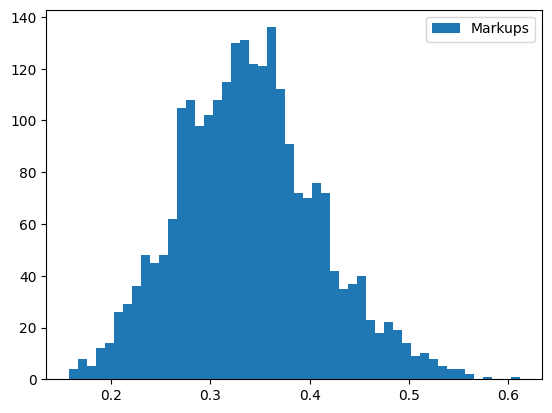

In [24]:
costs = res_joint.compute_costs()
hhi = res_joint.compute_hhi()
profits = res_joint.compute_profits(costs=costs)
cs = res_joint.compute_consumer_surpluses()

markups = res_joint.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

[[3.27298753]
 [2.65000905]
 [2.05752051]
 ...
 [2.79712375]
 [2.9820461 ]
 [2.44576078]]


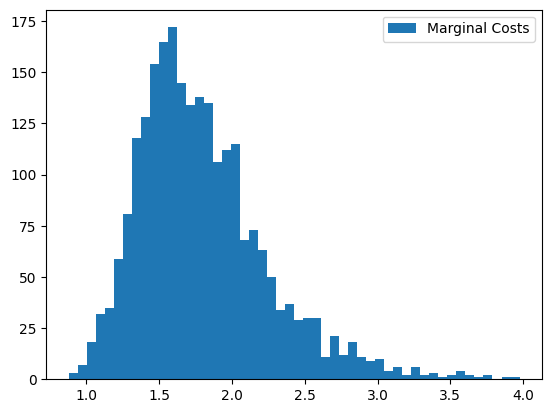

In [25]:
product_data_11 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_11['merger_ids'] = product_data_11['firm_ids'].replace(2, 1)

changed_prices_11 = res_joint.compute_prices(
    firm_ids=product_data_11['merger_ids'],
    costs=costs
)
print(changed_prices_11)

changed_shares = res_joint.compute_shares(changed_prices_11)



### 12

[[2.88653881]
 [2.61435052]
 [2.08848736]
 ...
 [2.76681251]
 [3.01245564]
 [2.44629933]]


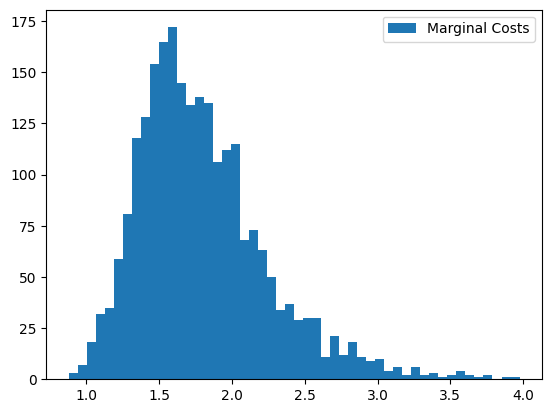

In [26]:
product_data_12 = product_data.copy()

plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_12['merger_ids'] = product_data_12['firm_ids'].replace(3, 1)

changed_prices_12 = res_joint.compute_prices(
    firm_ids=product_data_12['merger_ids'],
    costs=costs
)
print(changed_prices_12)

changed_shares = res_joint.compute_shares(changed_prices_12)



In [33]:
base_prices = product_data['prices'].values[:,None]  # shape (T*J,)

# --- Merger 11 results (you already computed changed_prices_11) ---
delta_11 = changed_prices_11 - base_prices  # price change after merger 11

# --- Merger 12 results (you computed changed_prices_12 above) ---
delta_12 = changed_prices_12 - base_prices  # price change after merger 12


df_compare = pd.DataFrame({
    'market_id': product_data['market_ids'].values,
    'product_id': product_data['product_ids'].values,
    'baseline_price': base_prices[:,0],
    'post_merger_price_11': changed_prices_11[:,0],
    'post_merger_price_12': changed_prices_12[:,0],
    'delta_price_11': delta_11[:,0],
    'delta_price_12': delta_12[:,0]
})

# Average across markets: one row per product_id
avg_changes = df_compare.groupby('product_id')[['delta_price_11','delta_price_12']].mean()

# Rename columns for clarity in the table
avg_changes = avg_changes.rename(columns={
    'delta_price_11': 'Avg $\\Delta$Price: M. 11',
    'delta_price_12': 'Avg $\\Delta$Price: M. 12'
})

# Optional: add % changes too (across markets, average of \\%$\\Delta$p)
df_compare['pct_delta_11'] = delta_11 / base_prices * 100.0
df_compare['pct_delta_12'] = delta_12 / base_prices * 100.0
avg_pct_changes = df_compare.groupby('product_id')[['pct_delta_11','pct_delta_12']].mean()

avg_pct_changes = avg_pct_changes.rename(columns={
    'pct_delta_11': 'Avg \\%$\\Delta$Price: M. 11',
    'pct_delta_12': 'Avg \\%$\\Delta$Price: M. 12'
})

# Final table: merge levels and round
final_table = avg_changes.merge(
    avg_pct_changes,
    left_index=True,
    right_index=True
).round(4)

# Give nicer product labels
final_table.index.name = 'Product'
final_table.reset_index(inplace=True)

print(final_table)

final_table.to_latex(
    "latex/table_exercise_12_old.tex",
    index=False,
    float_format="%.4f",
    caption="Average Price Changes Due to Mergers",
    label="tab:exercise_12"
)


   Product  Avg $\Delta$Price: M. 11  Avg $\Delta$Price: M. 12  \
0        1                    0.1736                    0.1600   
1        2                    0.1609                    0.0064   
2        3                    0.0064                    0.1612   
3        4                    0.0062                    0.0058   

   Avg \%$\Delta$Price: M. 11  Avg \%$\Delta$Price: M. 12  
0                      6.5808                      6.0261  
1                      6.0886                      0.2444  
2                      0.2448                      6.0385  
3                      0.2375                      0.2238  


In [34]:
# --- After creating final_table as you did ---
final_table_oneColumn = avg_changes.merge(
    avg_pct_changes,
    left_index=True,
    right_index=True
).round(4)

# Reset index to get 'Product' as a column, not index
final_table_oneColumn.index.name = 'Product'
final_table_oneColumn.reset_index(inplace=True)

# --- Create a nice 2-level column structure ---
final_table_oneColumn.columns = pd.MultiIndex.from_tuples([
    ('', 'Product'),
    ('Merger 11', '$\\Delta$Price'),
    ('Merger 12', '$\\Delta$Price'),
    ('Merger 11', '\\%$\\Delta$Price'),
    ('Merger 12', '\\%$\\Delta$Price')
])

final_table_oneColumn.to_latex(
    "latex/table_exercise_12.tex",
    index=False,
    float_format="%.4f",
    multicolumn=True,
    multicolumn_format='c',
    caption="Average Price Changes Due to Mergers",
    label="tab:exercise_12"
)


### 14

[[3.05471032]
 [2.52517861]
 [2.05333452]
 ...
 [2.54467842]
 [2.97719047]
 [2.42183638]]


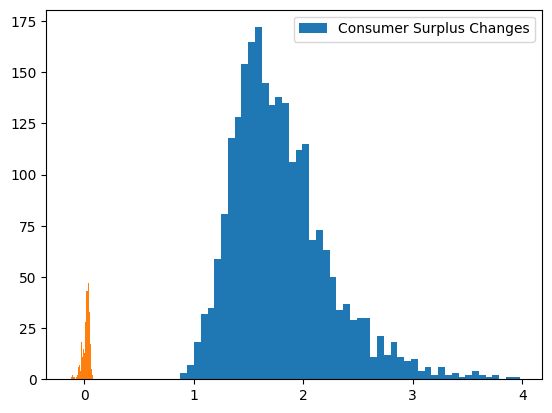

In [29]:
product_data_14 = product_data.copy()
merged_costs = costs.copy()
plt.hist(merged_costs, bins=50);
plt.legend(["Marginal Costs"]);
product_data_14['merger_ids'] = product_data_14['firm_ids'].replace(2, 1)

merged_costs[product_data_14.merger_ids== 1]= 0.85*merged_costs[product_data_14.merger_ids== 1]

changed_prices_14 = res_joint.compute_prices(
    firm_ids=product_data_14['merger_ids'],
    costs=merged_costs
)
print(changed_prices_14)

changed_shares = res_joint.compute_shares(changed_prices_14)
profit_changed = res_joint.compute_profits(costs=merged_costs, prices=changed_prices_14)

changed_cs = res_joint.compute_consumer_surpluses(changed_prices_14)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [30]:
delta_14 = changed_prices_14 - base_prices  # price change after merger 14


df_compare_14 = pd.DataFrame({
    'market_id': product_data['market_ids'].values,
    'product_id': product_data['product_ids'].values,
    'baseline_price': base_prices[:,0],
    'post_merger_price_11': changed_prices_11[:,0],
    'post_merger_price_12': changed_prices_12[:,0],
    'post_merger_price_14': changed_prices_14[:,0],
    'delta_price_11': delta_11[:,0],
    'delta_price_12': delta_12[:,0],
    'delta_price_14': delta_14[:,0]
})

# Average across markets: one row per product_id
avg_changes = df_compare_14.groupby('product_id')[['delta_price_11','delta_price_12','delta_price_14']].mean()

# Rename columns for clarity in the table
avg_changes = avg_changes.rename(columns={
    'delta_price_11': 'Avg $\\Delta$Price: M. 11',
    'delta_price_12': 'Avg $\\Delta$Price: M. 12',
    'delta_price_14': 'Avg $\\Delta$Price: M. 14'
})

# Optional: add % changes too (across markets, average of %Δp)
df_compare_14['pct_delta_11'] = delta_11 / base_prices * 100.0
df_compare_14['pct_delta_12'] = delta_12 / base_prices * 100.0
df_compare_14['pct_delta_14'] = delta_14 / base_prices * 100.0
avg_pct_changes = df_compare_14.groupby('product_id')[['pct_delta_11','pct_delta_12','pct_delta_14']].mean()

avg_pct_changes = avg_pct_changes.rename(columns={
    'pct_delta_11': 'Avg \\%$\\Delta$Price: M. 11',
    'pct_delta_12': 'Avg \\%$\\Delta$Price: M. 12',
    'pct_delta_14': 'Avg \\%$\\Delta$Price: M. 14'
})

# Final table: merge levels and round
final_table = avg_changes.merge(
    avg_pct_changes,
    left_index=True,
    right_index=True
).round(4)

# Give nicer product labels
final_table.index.name = 'Product'
final_table.reset_index(inplace=True)

print(final_table)

final_table.to_latex(
    "latex/table_exercise_14.tex",
    index=False,
    float_format="%.4f",
    caption="Average Price Changes Due to Mergers",
    label="tab:exercise_14"
)




   Product  Avg $\Delta$Price: M. 11  Avg $\Delta$Price: M. 12  \
0        1                    0.1736                    0.1600   
1        2                    0.1609                    0.0064   
2        3                    0.0064                    0.1612   
3        4                    0.0062                    0.0058   

   Avg $\Delta$Price: M. 14  Avg \%$\Delta$Price: M. 11  \
0                   -0.0195                      6.5808   
1                   -0.0290                      6.0886   
2                   -0.0044                      0.2448   
3                   -0.0044                      0.2375   

   Avg \%$\Delta$Price: M. 12  Avg \%$\Delta$Price: M. 14  
0                      6.0261                     -0.4568  
1                      0.2444                     -0.8455  
2                      6.0385                     -0.1699  
3                      0.2238                     -0.1740  


In [31]:
profits = res_joint.compute_profits(costs=costs)
cs = res_joint.compute_consumer_surpluses()
total_welfare = cs.sum() / T
total_welfare_cs =  profit_changed.sum() / T

out_path = Path("latex/scalars_exercise_15.tex").resolve()
latex_str = f"\\newcommand{{\\TotalWelfare}}{{{total_welfare:.3f}}}\n"
latex_str_changed_cs = f"\\newcommand{{\\TotalWelfareChangedCS}}{{{(total_welfare_cs):.3f}}}\n"
latex_str_difference = f"\\newcommand{{\\WelfarePercentage}}{{{((total_welfare_cs/total_welfare -1) * 100):.3f}}}\n"
string = latex_str + "\n" + latex_str_changed_cs + "\n" + latex_str_difference
out_path.write_text(string, encoding="utf-8")
print(f"\nLaTeX scalar written to: {out_path}")



LaTeX scalar written to: C:\Users\stefa\Desktop\Milena Projects\ProbelmsetIO\ps3\Latex\scalars_exercise_15.tex
